In [1]:
%cd /home/ltchen/gnnpp
import pandas as pd
import sys
import json
import copy
from torch_geometric.loader import DataLoader
from torch.utils.data import TensorDataset
import matplotlib.pyplot as plt
from scipy.stats import norm
from exploration.get_graphs_and_data import *
from utils.explainability_utils import *
from utils.plot import *
from models.loss import *
from utils.plot import *
import seaborn as sns


/home/ltchen/gnnpp


In [2]:
leadtime = "24h"
graph_name = "drn" # adjust to "drn" if drn = True
drn = True
DATASET = "f"

JSONPATH, SAVEPATH, RESULTPATH = get_json_save_result_paths(leadtime=leadtime, graph_name=graph_name, drn=drn)
predictions = pd.read_csv(os.path.join(RESULTPATH, f"{DATASET}_{graph_name}_{leadtime}_results.csv"))
predictions = predictions.dropna(axis=0)
RESULTPATH

'/home/ltchen/gnnpp/leas_trained_models/drn_24h'

In [3]:
DIRECTORY = os.getcwd()
print(DIRECTORY)
FIGUREPATH = os.path.join(DIRECTORY, 'figures')
os.makedirs(FIGUREPATH, exist_ok=True)

def calculate_rank(row):
    combined_list = row['ensembles'] + [row['t2m']]
    sorted_list = sorted(combined_list)
    rank = sorted_list.index(row['t2m'])  # +1 to convert from 0-based to 1-based index
    return rank

/home/ltchen/gnnpp


In [8]:
# PIT
predictions

,t2m,mu,sigma
0,278.65,279.091614,0.591957
1,275.25,275.917755,0.954671
2,279.75,279.473572,0.566059
3,279.15,279.261841,0.679912
4,275.05,273.767761,0.903569
...,...,...,...
86737,277.95,278.292389,1.313726
86738,276.85,277.400696,1.173687
86739,276.35,276.176575,1.410956
86740,270.65,271.240143,1.046467


In [4]:
# y = torch.tensor(predictions["t2m"].to_numpy())
# preds = torch.tensor(predictions[["mu", "sigma"]].to_numpy())
y = predictions["t2m"].to_numpy()
mu = predictions["mu"].to_numpy()
sigma = predictions["sigma"].to_numpy()

In [6]:
normalCRPS = NormalCRPS()
err = normalCRPS.crps(mu_sigma=torch.tensor(predictions[["mu", "sigma"]].to_numpy()),
                      y=torch.tensor(predictions["t2m"].to_numpy())).item()
err

0.6057152649441763

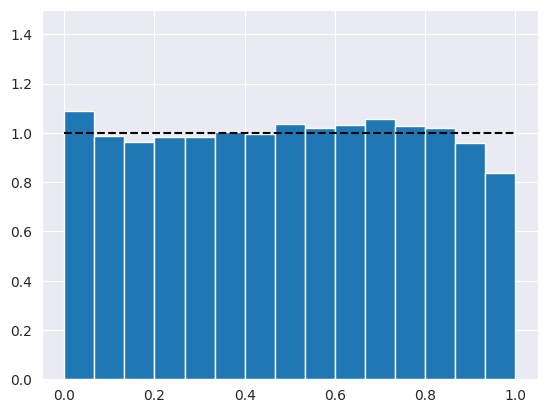

In [7]:
# PIT for 120h
probs = norm.cdf(y.flatten(), loc=mu.flatten(), scale=sigma.flatten())  # scale is standard deviation
n, bins, patches = plt.hist(probs, bins=15, density=True)

bin_centers = 0.5 * (bins[:-1] + bins[1:])

# scale values to interval [0,1]
col = bin_centers - min(bin_centers)
col /= (max(col))

plt.ylim(0, 1.5)  # Layout
plt.hlines(xmin=0, xmax=1, y=1, colors="black", linestyles="--")

## 72h lead time, raw, drn, g1, g3, g4, g5 - f & rf

[INFO] Dataframes exist. Will load pandas dataframes.


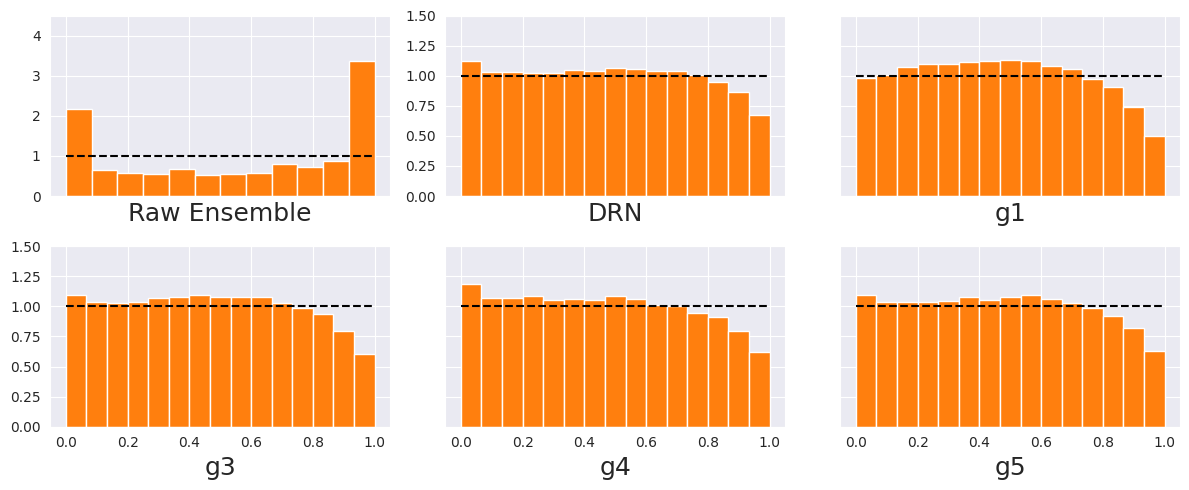

In [10]:
LEADTIME = "72h"
# graph_name = "drn" # adjust to "drn" if drn = True
# drn = True
DATASET = "f"

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 5), sharex=True, sharey=False)  # Shared x and y axes

# Loop through each dataset
for i in range(0,2):
    for j in range(0,3):
        ax = axes[i, j]  # Get the subplot for this combination
        if ((i == 0) and (j == 0)):
            # plot raw ensemble
            graph_name = 'Raw Ensemble'
            dataframes = load_dataframes(leadtime=LEADTIME)
            test_df = dataframes[f'test_{DATASET}'][0]
            test_target_df = dataframes[f'test_{DATASET}'][1]

            df2 = test_df.groupby(['time', 'station_id'])['t2m'].apply(list).reset_index(name="ensembles")
            df2, test_target_df = drop_nans((df2, test_target_df))

            if DATASET == "f":
                ens_plus_one = 51
            else:
                ens_plus_one = 11
            df3 = pd.merge(df2, test_target_df, on=['time', 'station_id'])
            df3['rank'] = df3.apply(calculate_rank, axis=1)
            df3['rank'].value_counts()
            n, bins, patches = ax.hist((df3['rank']/ens_plus_one), density=True, bins=12, color = '#ff7f0e') # bins=15, edgecolor='black',
            bin_centers = 0.5 * (bins[:-1] + bins[1:])
            ax.set_ylim(0, 4.5)
        else:
            if ((i == 0) and (j == 1)):
                drn = True
                graph_name = "drn"
                JSONPATH, SAVEPATH, RESULTPATH = get_json_save_result_paths(leadtime=LEADTIME, graph_name=graph_name, drn=drn)
                predictions = pd.read_csv(os.path.join(RESULTPATH, f"{DATASET}_{graph_name}_{LEADTIME}_results.csv"))
                predictions = predictions.dropna(axis=0)
                graph_name = "DRN"
            elif ((i == 0) and (j == 2)):
                drn = False
                graph_name = "g1"
                JSONPATH, SAVEPATH, RESULTPATH = get_json_save_result_paths(leadtime=LEADTIME, graph_name=graph_name, drn=drn)
                predictions = pd.read_csv(os.path.join(RESULTPATH, f"{DATASET}_{graph_name}_{LEADTIME}_results.csv"))
                predictions = predictions.dropna(axis=0)
            else:
                drn = False
                graph_name = f"g{j+3}"
                # name = r'$g_{j+3}$'
                JSONPATH, SAVEPATH, RESULTPATH = get_json_save_result_paths(leadtime=LEADTIME, graph_name=graph_name, drn=drn)
                predictions = pd.read_csv(os.path.join(RESULTPATH, f"{DATASET}_{graph_name}_{LEADTIME}_results.csv"))
                predictions = predictions.dropna(axis=0)

            y = predictions["t2m"].to_numpy()
            mu = predictions["mu"].to_numpy()
            sigma = predictions["sigma"].to_numpy()

            probs = norm.cdf(y.flatten(), loc=mu.flatten(), scale=sigma.flatten())  # scale is standard deviation
            n, bins, patches = ax.hist(probs, bins=15, density=True, color= '#ff7f0e')

            # colors
            # cm = get_color(LEADTIME)  # Assuming MODEL is defined somewhere in your code
            bin_centers = 0.5 * (bins[:-1] + bins[1:])
            ax.set_ylim(0, 1.5)


        # scale values to interval [0,1]
        col = bin_centers - min(bin_centers)
        col /= (max(col))

        # for c, p in zip(col, patches):
        #     p.set_facecolor(cm(c))

          # Layout
        ax.hlines(y=1, xmin=0, xmax=1, colors="black", linestyles="--")
        ax.set_xlabel(graph_name, fontsize=18)
        if graph_name in ["g1", "g4", "g5"]:
            ax.set_yticklabels([])

plt.tight_layout()  # Adjust subplot parameters to give specified padding.
plt.savefig(os.path.join(FIGUREPATH, f"{LEADTIME}_pit_histogram_{DATASET}.pdf"), format='pdf', dpi=300, bbox_inches='tight')

## All lead times, all graphs

In [8]:
def get_colors(name):
    if "24h" in name:
        return "#1f77b4"
    elif "72h" in name:
        return "#ff7f0e"
    elif "120h" in name:
        return "#2ca02c"
    else:
        return cmr.get_sub_cmap(cmr.amber,0.3,0.8)


/home/ltchen/gnnpp/figures


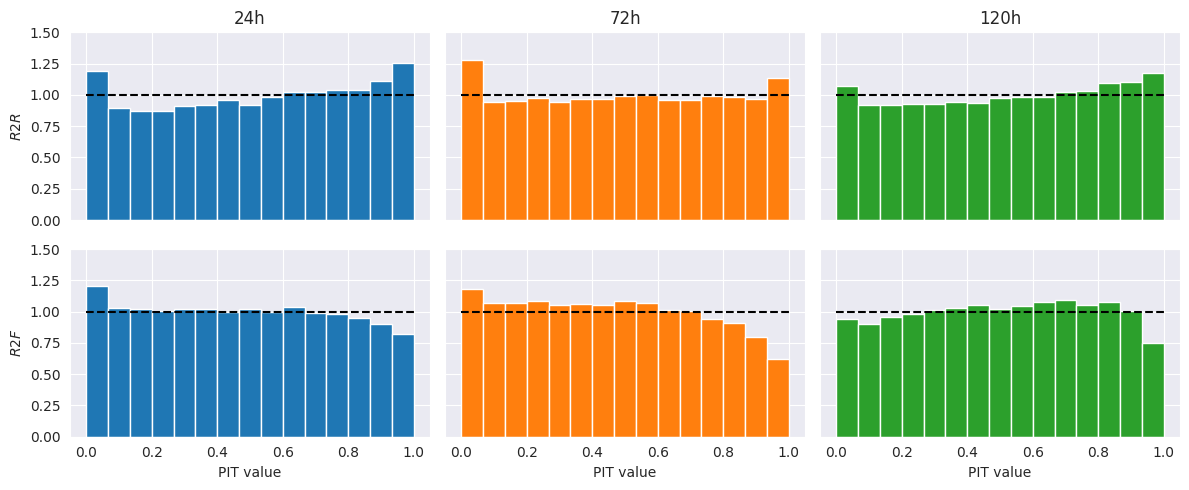

In [20]:
leadtime = ["24h", "72h", "120h"]
GRAPH_NAME = "g4" # adjust to "drn" if drn = True
drn = False
DATASET = ["rf", "f"]

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 5), sharex=True, sharey=True)  # Shared x and y axes

# Loop through each dataset
for i, d in enumerate(DATASET):
    for j, m in enumerate(leadtime):
        ax = axes[i, j]  # Get the subplot for this combination
        JSONPATH, SAVEPATH, RESULTPATH = get_json_save_result_paths(leadtime=m, graph_name=GRAPH_NAME, drn=drn)
        predictions = pd.read_csv(os.path.join(RESULTPATH, f"{d}_{GRAPH_NAME}_{m}_results.csv"))
        predictions = predictions.dropna(axis=0)
        y = predictions["t2m"].to_numpy()
        mu = predictions["mu"].to_numpy()
        sigma = predictions["sigma"].to_numpy()

        # Calc Z values
        probs = norm.cdf(y.flatten(), loc=mu.flatten(), scale=sigma.flatten())  # scale is standard deviation
        n, bins, patches = ax.hist(probs, bins=15, density=True)

        # colors
        cm = get_colors(m)  # Assuming MODEL is defined somewhere in your code
        bin_centers = 0.5 * (bins[:-1] + bins[1:])

        # scale values to interval [0,1]
        col = bin_centers - min(bin_centers)
        col /= (max(col))

        for c, p in zip(col, patches):
            p.set_facecolor(cm)

        ax.set_ylim(0, 1.5)  # Layout
        ax.hlines(y=1, xmin=0, xmax=1, colors="black", linestyles="--")
        if i == 0:
            #ax.set_title(r"\SI{24}{\hour}" if m == "best_24h" else r"\SI{72}{\hour}" if m == "best_72h" else r"\SI{120}{\hour}")
            ax.set_title("24h" if "24h" in m else "72h" if "72h" in m else "120h")
        if i == 1:
            ax.set_xlabel('PIT value')
        if j == 0:
            ax.set_ylabel('$\t{R2R}$' if d == "rf" else '$\t{R2F}$')

plt.tight_layout()  # Adjust subplot parameters to give specified padding.
plt.savefig(os.path.join(FIGUREPATH, f"pit_histograms_{GRAPH_NAME}.pdf"), format='pdf', dpi=300, bbox_inches='tight')
print(FIGUREPATH)
# tikzplotlib.save(os.path.join(FIGUREPATH, f"pit_histograms_{GRAPH_NAME}.tex")

[INFO] Dataframes exist. Will load pandas dataframes.
[INFO] Dataframes exist. Will load pandas dataframes.
[INFO] Dataframes exist. Will load pandas dataframes.
[INFO] Dataframes exist. Will load pandas dataframes.
[INFO] Dataframes exist. Will load pandas dataframes.
[INFO] Dataframes exist. Will load pandas dataframes.


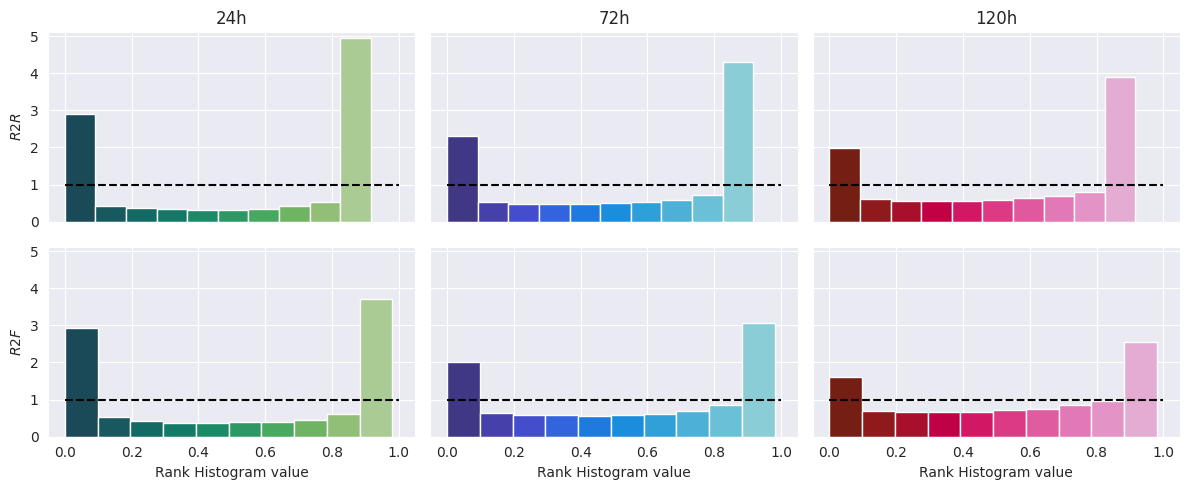

In [32]:
# rank histogram for raw predictions
leadtime = ["24h", "72h", "120h"]
DATASET = ["rf", "f"]

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 5), sharex=True, sharey=True)  # Shared x and y axes

# Loop through each dataset
for i, d in enumerate(DATASET):
    for j, m in enumerate(leadtime):
        ax = axes[i, j]  # Get the subplot for this combination
        dataframes = load_dataframes(leadtime=m)
        test_df = dataframes[f'test_{d}'][0]
        test_target_df = dataframes[f'test_{d}'][1]

        df2 = test_df.groupby(['time', 'station_id'])['t2m'].apply(list).reset_index(name="ensembles")
        df2, test_target_df = drop_nans((df2, test_target_df))

        if d == "f":
            ens_plus_one = 52
        else:
            ens_plus_one = 12
        df3 = pd.merge(df2, test_target_df, on=['time', 'station_id'])
        df3['rank'] = df3.apply(calculate_rank, axis=1)
        df3['rank'].value_counts()


        n, bins, patches = ax.hist((df3['rank']/ens_plus_one), density=True) # bins=15, edgecolor='black',

        # colors
        cm = get_color(m)  # Assuming MODEL is defined somewhere in your code
        bin_centers = 0.5 * (bins[:-1] + bins[1:])

        # scale values to interval [0,1]
        col = bin_centers - min(bin_centers)
        col /= (max(col))

        for c, p in zip(col, patches):
            p.set_facecolor(cm(c))

        ax.set_ylim(0, 5.1)  # Layout
        ax.hlines(y=1, xmin=0, xmax=1, colors="black", linestyles="--")
        if i == 0:
            #ax.set_title(r"\SI{24}{\hour}" if m == "best_24h" else r"\SI{72}{\hour}" if m == "best_72h" else r"\SI{120}{\hour}")
            ax.set_title("24h" if "24h" in m else "72h" if "72h" in m else "120h")
        if i == 1:
            ax.set_xlabel('Rank Histogram value')
        if j == 0:
            ax.set_ylabel('$\t{R2R}$' if d == "rf" else '$\t{R2F}$')

plt.tight_layout()  # Adjust subplot parameters to give specified padding.
plt.savefig(os.path.join(FIGUREPATH, f"rank_histograms_raw.pdf"), format='pdf', dpi=300, bbox_inches='tight')